In [1]:
from pathlib import Path
import pandas as pd
import os

data_dir = Path(os.environ["PARENT_SLURM_DIR"])
jobs = [
    "IOPFPlanets20220810",
    "IOPFPlanets20220820",
    "IOPFPlanets20220822Narrow",
    "IOPFPlanets20220927",
    "IOPFPlanets20220928ALPHA",
    "IOPFPlanets20220928GRADUAL",
    "IOPFPlanets20220928SCALETORQUE"
]

argfiles = [argfile for job in jobs for argfile in (data_dir / job).glob("*/args.json")]
sims_records = pd.DataFrame.from_records(pd.read_json(argfile, typ="series") for argfile in argfiles)
sims_paths = pd.DataFrame.from_records({"run": argfile.parent.name, "path": argfile.parent} for argfile in argfiles)
sims_df = pd.concat([sims_records, sims_paths], axis="columns")

import matplotlib

matplotlib.colors.ColorConverter.colors['cassum:orange'] = "#e77a35"
matplotlib.colors.ColorConverter.colors['cassum:blue'] = "#3b8ce2"

matplotlib.colors.cnames['cassum:orange'] = "#e77a35"
matplotlib.colors.cnames['cassum:blue'] = "#3b8ce2"

In [2]:
import rebound

sim_cache = {}
for i, rebound_path in (sims_df["path"] / sims_df["rebound_archive"]).items():
    sa = rebound.SimulationArchive(str(rebound_path))
    final = sa[-1]
    sim_cache[sims_df.at[i, "run"]] = {
        "sa": sa,
        "final": final,
        "byindex": {

        },
        "h5path": next(sims_df.at[i, "path"].glob("*.h5"))
    }

def load_sim_from_cache(run, time):
    sa = sim_cache[run]["sa"]
    _i, _ = sa._getSnapshotIndex(time)
    if _i in sim_cache[run]["byindex"]:
        return sim_cache[run]["byindex"][_i]
    else:
        sim = sa[_i]
        sim_cache[run]["byindex"][_i] = sim
        return sim

/priv/c3-astro-scratch1/iostelea/bert/bert-python/src/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [14]:
import numpy as np

NaN = float("NaN")

def FINAL_STATS(sim):
    final = sim_cache[sim["run"]]["final"]
    
    stats = np.array([(p.m, p.a, p.P) for p in final.particles[1:]]).T
    N = len(stats[0])
    M_TOT = stats[0].sum()

    top2 = stats[:, np.argsort(stats[0])[-1:-3:-1]]
    if N < 2:
        top2 = np.column_stack([top2, np.full_like(top2, NaN)])
    
    m, a, P = top2  

    return pd.Series({
        "FINAL_N": N,
        # "FINAL_M_TOT": M_TOT,

        # "FINAL_M_PRI": m[0],
        # "FINAL_P_PRI": P[0],
        # "FINAL_A_PRI": a[0],

        # "FINAL_M_SEC": m[1],
        # "FINAL_P_SEC": P[1],
        # "FINAL_A_SEC": a[1],

        "FINAL_M_RAT_PRI_TOT": m[0] / M_TOT,
        # "FINAL_M_RAT_SEC_TOT": m[1] / M_TOT,
        # "FINAL_M_RAT_PRI_SEC": m[0] / m[1],
        # "FINAL_P_RAT_PRI_SEC": P[0] / P[1],
    })

final_df = sims_df.apply(FINAL_STATS, axis=1)
final_df["FINAL_N"] = final_df["FINAL_N"].astype(np.int_)
sims_ext_df = sims_df.join(final_df)

In [15]:
# Select only torque and drag on cases

sims_ext_df = sims_ext_df[(sims_ext_df["C_d"] > 0.4) & sims_ext_df["migration_torque"]]

# Define our grouping function
def custom_grouper(label):
    row = sims_ext_df.loc[label]
    if row["pa_rate"] != 0.0:
        return "pebble_accretion"
    if row["alpha"] == "-4":
        return "steep_alpha"
    if row["introduction_time"] == 300000.0:
        return "gradual_introduction"
    if row["torque_scale"] == 100.0:
        return "scale_torque_100"
    if row["torque_scale"] == 10.0:
        return "scale_torque_10"
    return "drag_torque"

In [16]:
# groups = sims_ext_df.groupby(["pa_beta", "alpha", ""])

groups = sims_ext_df.groupby(custom_grouper)
dgroups = dict(list(groups))

# mins = groups.min().add_suffix("_MIN")
# maxes = groups.max().add_suffix("_MAX")
# means = groups.mean().add_suffix("_MEAN")
# medians = groups.median().add_suffix("_MEDIAN")

# summary = pd.concat([
#     # mins,
#     # maxes,
#     # means,
#     # medians,
# ], axis=1).filter(like="FINAL")

summary = groups.agg([
    "min",
    "max",
    "mean",
    "median",
    # "count"
]).filter(like="FINAL")

summary

/apps/Vera/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/apps/Vera/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/apps/Vera/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/apps/Vera/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/apps/Vera/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out

FINAL_N                     FINAL_M_RAT_PRI_TOT  \
                         min max     mean median                 min   
drag_torque                3   7  4.78125    5.0            0.335261   
gradual_introduction       3   6  4.93750    5.0            0.456548   
pebble_accretion           2   5  3.75000    4.0            0.464069   
scale_torque_10            3   6  4.12500    4.0            0.410000   
scale_torque_100           3   5  3.62500    3.5            0.750000   
steep_alpha                2   7  4.50000    4.5            0.397806   

                                                    
                           max      mean    median  
drag_torque           0.779093  0.542715  0.545947  
gradual_introduction  0.720625  0.598255  0.604150  
pebble_accretion      0.998108  0.778147  0.773688  
scale_torque_10       0.700000  0.545000  0.560000  
scale_torque_100      0.950000  0.852500  0.845000  
steep_alpha           0.782318  0.585655  0.589848

In [9]:
import numpy as np

Ts = np.concatenate([
    np.arange(0.0, 1000, 10.0),
    np.arange(1000.0, 100000.0, 1000.0),
    np.arange(100000.0, 1000000.0, 10000.0),
    np.arange(1000000.0, 2000000+1, 100000.0)]
)

targets = [
    "drag_torque",
    "gradual_introduction",
    "pebble_accretion",
    "steep_alpha",
    "scale_torque_10",
    "scale_torque_100"
]

target_data = [(target, dgroups[target], np.empty((len(dgroups[target]), len(Ts), 4))) for target in targets]

for _, df, dest in target_data:
    for i, row in df.reset_index().iterrows():
        p = str(row["path"] / row["rebound_archive"])
        sa = rebound.SimulationArchive(p)
        for j, t in enumerate(Ts):
            sim = sa.getSimulation(t)
            dest[i, j, 0] = sim.N - 1

            m, a = np.array([(p.m, p.a) for p in sim.particles[1:]]).T
            ipri = np.argmax(m)
            dest[i, j, 1] = m[ipri] / np.sum(m)
            wstd = np.sqrt(np.sum(m * (a - np.average(a, weights=m))**2) / sum(m * a))
            dest[i, j, 2] = wstd

target_means = [np.mean(dest, axis=0) for _, _, dest in target_data]

/apps/Vera/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


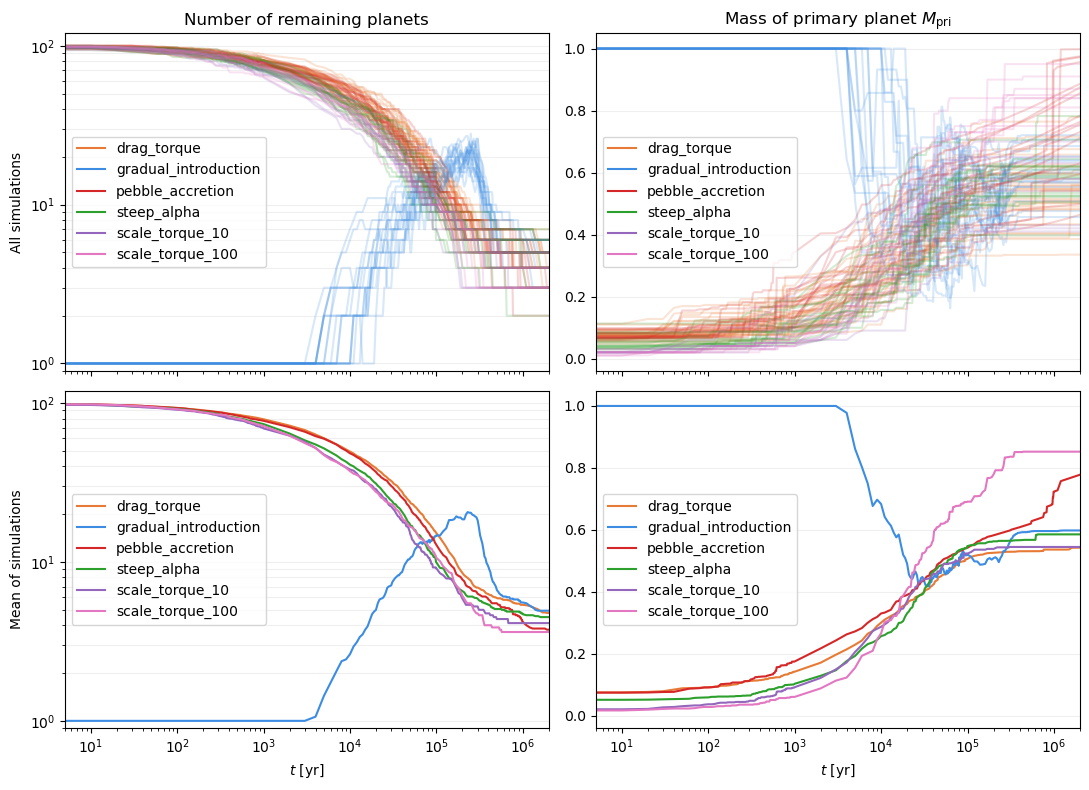

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler
import matplotlib

# fg = "#ccc"

# plt.rc("axes", prop_cycle=cycler(color=["3b8ce2"]), facecolor="202020", labelcolor=fg, edgecolor=fg)
# plt.rc("figure", facecolor="none")
# plt.rc("xtick", color=fg, labelcolor=fg)
# plt.rc("ytick", color=fg, labelcolor=fg)
# plt.rc("text", color=fg)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

target_colors = [
    "cassum:orange",
    "cassum:blue",
    "tab:red",
    "tab:green",
    "tab:purple",
    "tab:pink"
]

fig, axs = plt.subplots(2, 2, figsize=(11, 8), sharex=True, sharey="col")
target_handles = []

for col in range(2):
    ax = axs[1, col]

    for (target, _, _), mean, color in zip(target_data, target_means, target_colors):
        l = ax.plot(Ts, mean[:, col], color=color, label=target)
        target_handles.append(l[0])

    ax.set_xlabel(r"$t$ [yr]")

    ax = axs[0, col]

    for (target, _, dest), _, color in zip(target_data, target_means, target_colors):
        for row in dest:
            ax.plot(Ts, row[:, col], color=color, alpha=0.2)


# ax.set_ylabel(r"Number of suriving planets")

ax = axs[0][0]
ax.set_xscale("log")
ax.set_xlim(5, 2000000.0)
ax.set_ylim(0.9, 120)
ax.set_yscale("log")
ax.set_title("Number of remaining planets")

ax.set_ylabel("All simulations")

axs[0][1].set_title("Mass of primary planet $M_{\\mathrm{pri}}$")
# axs[0][1].set_ylim(0, 0.1)

# axs[0][2].set_title("Weighted mean $i$")
# axs[0][2].set_ylim(0, 0.05)

axs[1][0].set_ylabel("Mean of simulations")

for ax in np.ravel(axs):
    ax.legend(handles=target_handles[:6])
    ax.grid(which="both", axis="y", alpha=0.2)

fig.tight_layout()

plt.savefig("images/mod_compare.png")
plt.show()